# Implementation with CuPy and JIT


In [1]:
no_samples=1000
no_features=10
no_classes=2

TPB = 16

## Data Preparation

(1000, 10)
(1000,)


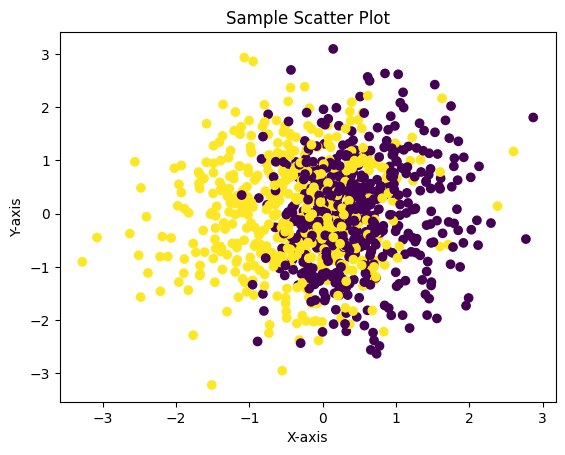

In [2]:
# Test on dummy data
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Generate data with 10 features, 1000 samples, and 2 classes with informative features
X, y = make_classification(n_samples=no_samples, n_features=no_features, n_classes=no_classes, random_state=42)

# X is the data (features), y are the labels (class assignments)
print(X.shape)  # Output: (100, 4) - 100 samples with 4 features each
print(y.shape)  # Output: (100,) - 100 labels (0 or 1)

# Create the scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y)  # Using first two columns of X for x and y axes

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Sample Scatter Plot")

# Display the plot
plt.show()

## Create CPU Code First

In [3]:
# CPU Code First

import numpy as np
import pandas as pd
import math

# The input layer
# Load and ready the data to be passed to the hidden layer
def cpu_inputLayer(inputVec):
  vecToReturn = np.array(inputVec)
  return vecToReturn

# Once the input layer has received the input values
# The values are now ready to pass to the next layer
# This is now the hidden layer
def cpu_hiddenLayer(numNodes, inputLayer):
  # Accept the number of nodes for this hidden layer
  # Accepts the previous layer
  layerToReturn = []
  bias = np.random.random()

  # Per node, compute the product of the inputLayer and the randomized inputWeights
  for i in range(no_features):
    weights = np.random.random(no_features)
    layerToReturn.append(np.dot(inputLayer, weights) + bias)
    # Add the bias term to the node's sum

  # This layer outputs a vector containing the individual values per node
  # That must be passed to the individual node's activation function
  # Note: This function must be called multiple times if more layers are generated
  return layerToReturn

# This function is called to change the values of the input values
# Based on chosen activation function
def cpu_activationFunc(inputVector, activation = ""):
  activation = activation.lower()

  for i in inputVector:
    if activation == "sigmoid":
      i = (1 / 1 + np.exp(-1 * i))
    elif activation == "relu":
      i = np.max([0.01 * i, i])
    elif activation == "linear":
      i = i # No changes

  return inputVector

def cpu_outputLayer(prevLayer):
  outputLayer = cpu_hiddenLayer(no_classes, prevLayer)
  outputLayer = cpu_activationFunc(outputLayer, "sigmoid")

  return max(outputLayer), np.argmax(outputLayer)

## CPU Model Testing

In [4]:
# Model Testing Function

def testCPU(inputData):
  for i in range(len(inputData)):
    mlp_inputLayer = cpu_inputLayer(X[i])
    mlp_hiddenLayer1 = cpu_hiddenLayer(8, mlp_inputLayer)
    mlp_hiddenLayer1 = cpu_activationFunc(mlp_hiddenLayer1, "relu")
    mlp_hiddenLayer2 = cpu_hiddenLayer(5, mlp_hiddenLayer1)
    mlp_hiddenLayer2 = cpu_activationFunc(mlp_hiddenLayer2, "relu")
    mlp_outputLayer = cpu_outputLayer(mlp_hiddenLayer2)

In [5]:
import time

start_cpu = time.perf_counter()
testCPU(X)
end_cpu = time.perf_counter()
t_cpu = end_cpu - start_cpu

print("CPU Execution Time: ", t_cpu)

CPU Execution Time:  0.16084120189771056


## Implementation using CuPy

In [6]:
# GPU Code First with CuPy

import cupy as cp
from cupyx import jit
import numpy as np
import math

nodeSum_kernel = cp.ReductionKernel(
    'T x, U y',  # input params
    'T z',  # output params
    'x * y',  # map
    'a + b',  # reduce
    'z = a',  # post-reduction map
    '0',  # identity value
    'nodeSum_kernel'  # kernel name
)

# The input layer
# Load and ready the data to be passed to the hidden layer
def cupy_inputLayer(inputVec):
  # Create array in the GPU
  vecToReturn = cp.array(inputVec)
  return vecToReturn

def generate_random_weights(numFeatures):
  # Generate weights for all nodes at once
  return cp.random.random(numFeatures)

# Part of this is parallelizable
def cupy_hiddenLayer(numNodes, inputLayer):
  # Accept the number of nodes for this hidden layer
  # Accepts the previous layer
  layerToReturn = cp.zeros(no_features)
  bias = cp.random.random()

  # Per node, compute the product of the inputLayer and the randomized inputWeights
  for i in range(no_features):
    weights = cp.random.random(no_features)
    #layerToReturn[i] = cp.dot(inputLayer, weights) + bias
    layerToReturn[i] = nodeSum_kernel(inputLayer, weights) + bias
    # Add the bias term to the node's sum

  # This layer outputs a vector containing the individual values per node
  # That must be passed to the individual node's activation function
  # Note: This function must be called multiple times if more layers are generated
  return layerToReturn

# Parallelized to be an element-wise copy
@cp.fuse(kernel_name='cupy_activationFunc')
def cupy_activationFunc(inputVector, outputVector, activation):

  def apply_activation(x):
    if activation == 1:
      return cp.reciprocal(1 + cp.exp(-1 * x))
    elif activation == 2:
      return cp.maximum(0.01 * x, x)
    elif activation == 3:
      return x
    else:
      raise ValueError("Invalid activation function")

  outputVector = apply_activation(inputVector)

def cupy_outputLayer(prevLayer):
  outputLayer = cupy_hiddenLayer(no_classes, prevLayer)
  outputLayer_y = cp.zeros(no_classes)
  cupy_activationFunc(outputLayer, outputLayer_y, 1)
  return cp.max(outputLayer), cp.argmax(outputLayer)

## GPU Testing

In [7]:
# Model Testing Function
# cupy_activationFunc(inputVector, outputVector, activation, size)
def testGPU_cupy(inputData):
  for i in range(len(inputData)):
    mlp_inputLayer = cupy_inputLayer(X[0])
    mlp_hiddenLayer1 = cupy_hiddenLayer(8, mlp_inputLayer)
    cupy_activationFunc(mlp_hiddenLayer1, mlp_hiddenLayer1, 2)
    mlp_hiddenLayer2 = cupy_hiddenLayer(5, mlp_hiddenLayer1)
    cupy_activationFunc(mlp_hiddenLayer2, mlp_hiddenLayer2, 2)
    mlp_outputLayer = cupy_outputLayer(mlp_hiddenLayer2)

In [8]:
start_gpu = cp.cuda.Event()
end_gpu = cp.cuda.Event()

start_gpu.record()
start_cpu = time.perf_counter()
testGPU_cupy(X)
end_cpu = time.perf_counter()
end_gpu.record()
end_gpu.record()
end_gpu.synchronize()
t_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
t_cpu = end_cpu - start_cpu

print("Execution Time measured with CUDA Event: ", t_gpu)
print("Execution Time measured with time: ", t_cpu)

Execution Time measured with CUDA Event:  1804.506103515625
Execution Time measured with time:  1.8044478869996965


## Implementation using Numba (GPU)

In [18]:
import cupy as cp
import numba as nb
import numpy as np
from __future__ import division
from numba import cuda, float32
import math

# The input layer
# Load and ready the data to be passed to the hidden layer
def numba_inputLayer(inputVec):
  # Create array in the GPU
  vecToReturn = np.array(inputVec)
  return vecToReturn

def numba_generateWeights(numFeatures):
  # Generate weights for all nodes at once
  return cp.random.random(numFeatures)

# Part of this is parallelizable
def numba_hiddenLayer(numNodes, inputLayer):
  # Accept the number of nodes for this hidden layer
  # Accepts the previous layer
  layerToReturn = cp.zeros(no_features)
  bias = cp.random.random()

  # Per node, compute the product of the inputLayer and the randomized inputWeights
  """for i in range(no_features):
    weights = cp.random.random(no_features)
    #layerToReturn[i] = cp.dot(inputLayer, weights) + bias
    layerToReturn[i] = nodeSum_kernel(inputLayer, weights) + bias
    # Add the bias term to the node's sum"""

  inputVec = np.array(inputLayer)
  weightVec = np.random.random(len(inputVec))

  A_global_mem = cuda.to_device(inputVec)
  B_global_mem = cuda.to_device(weightVec)
  C_global_mem = cuda.device_array(len(inputVec)) # [32 x 16] matrix result

# Configure the blocks
  threadsperblock = (TPB, TPB)
  blockspergrid_x = int(math.ceil(inputLayer.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(weightVec.shape[0] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  for i in range(numNodes):
      numba_nodeSum[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
      res = C_global_mem.copy_to_host()
      layerToReturn[i] = res + bias

  # This layer outputs a vector containing the individual values per node
  # That must be passed to the individual node's activation function
  # Note: This function must be called multiple times if more layers are generated
  return layerToReturn

@cuda.jit
def numba_nodeSum(inputVec, weightVec, nodeToSum):
    """
    Perform matrix multiplication of C = A * B
    Each thread computes one element of the result matrix C
    """

    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sInputVec = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sWeightVec = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    if x >= nodeToSum.shape[0] and y >= nodeToSum.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(int(inputVec.shape[1] / TPB)):
        # Preload data into shared memory
        sInputVec[tx, ty] = inputVec[x, ty + i * TPB]
        sWeightVec[tx, ty] = weightVec[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sInputVec[tx, j] * sWeightVec[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    nodeToSum[x, y] = tmp

# Parallelized to be an element-wise copy
@cuda.jit
def numba_activationFun(inputVector, outputVector, activation):
    tid = numba.cuda.threadIdx.x
    if tid < outputVector.size:
        if activation == 1:
          outputVector[tid] = cp.reciprocal(1 + cp.exp(-1 * inputVector[tid]))
        elif activation == 2:
          outputVector[tid] = cp.maximum(0.01 * inputVector[tid], inputVector[tid])
        elif activation == 3:
          outputVector[tid] = inputVector
        else:
          raise ValueError("Invalid activation function")

def numba_outputLayer(prevLayer):
  outputLayer_y = cp.zeros(no_classes)
  
  outputLayer = numba_hiddenLayer(no_classes, prevLayer)
  numba_activationFunc[blockspergrid, threadsperblock](outputLayer, outputLayer_y, 1)
    
  return cp.max(outputLayer), cp.argmax(outputLayer)

In [19]:
# Model Testing Function
# cupy_activationFunc(inputVector, outputVector, activation, size)
mlp_inputLayer = numba_inputLayer(X[0])
mlp_hiddenLayer1 = numba_hiddenLayer(8, mlp_inputLayer)
numba_activationFunc(mlp_hiddenLayer1, mlp_hiddenLayer1, 2)
mlp_hiddenLayer2 = numba_hiddenLayer(5, mlp_hiddenLayer1)
cupy_activationFunc(mlp_hiddenLayer2, mlp_hiddenLayer2, 2)
mlp_outputLayer = numba_outputLayer(mlp_hiddenLayer2)

/leonardo/pub/userexternal/sdigioia/sdigioia/env/Gabenv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:538: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


TypingError: Failed in cuda mode pipeline (step: nopython frontend)
tuple index out of range
During: typing of static-get-item at /tmp/ipykernel_2310821/1489642167.py (73)

File "../../../../../../../tmp/ipykernel_2310821/1489642167.py", line 73:
<source missing, REPL/exec in use?>
